# Simulations light inter

In [1]:
from __future__ import annotations

import os
import sys
import time as t
from datetime import date
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("../data") 
from archi_dict import archi_sorghum_angles as archi
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.display import build_scene, display_scene  # noqa: F401
from openalea.archicrop.simulation import (
    plot_constained_vs_pot,
    plot_constrainted_vs_realized,
    plot_faPAR,
    plot_PAR,
    run_simulations,
    write_netcdf,
)
from openalea.plantgl.all import Color3, Material, Scene  # noqa: F401

%gui qt

In [2]:
stics_color = "orange"
archicrop_color = "green"

In [3]:
tec_file_xml='../data/sorgho_tec.xml'
plt_file_xml='../data/proto_sorghum_plt.xml'
stics_output_file='../data/mod_ssorghum.sti'
weather_file = '../data/climsorj.meteo'
location = {  
'longitude': 3.87,
'latitude': 45,
'altitude': 800,
'timezone': 'Europe/Paris'}

In [4]:
seed = 18

In [5]:
day_str = "2025-09-01"
ds = xr.open_dataset(f"D:/PhD_Oriane/simulations_ArchiCrop/{day_str}/results_{seed}.nc")
ds

<xarray.Dataset> Size: 1MB
Dimensions:                 (time: 118, id: 2)
Coordinates:
  * id                      (id) int32 8B 0 1
  * time                    (time) datetime64[ns] 944B 1996-05-13 ... 1996-09-07
Data variables: (12/44)
    thermal_time            (time) float64 944B ...
    lai_stics               (time) float64 944B ...
    sen_lai_stics           (time) float64 944B ...
    height_stics            (time) float64 944B ...
    inc_par                 (time) float64 944B ...
    abs_par_stics           (time) float64 944B ...
    ...                      ...
    scurv                   (id) float64 16B ...
    curvature               (id) float64 16B ...
    phyllotactic_angle      (id) float64 16B ...
    filter_1                (id) bool 2B ...
    filter_2                (id) bool 2B ...
    filter_3                (id) bool 2B ...

In [6]:
# Retrieve STICS growth and senescence dynamics
dates = ds.time.values
dates = pd.to_datetime(dates)
dates = dates.strftime('%Y-%m-%d')
thermal_time = ds.thermal_time.values
leaf_area_plant = ds.lai_stics.values
sen_leaf_area_plant = ds.sen_lai_stics.values
height_canopy = ds.height_stics.values
par_incident = ds.inc_par.values
par_stics = ds.abs_par_stics.values
sowing_density = float(ds.sowing_density.values)

pot_la = dict(zip(ds.id.values, ds.pot_la.values))
pot_h = dict(zip(ds.id.values, ds.pot_h.values))
realized_la = dict(zip(ds.id.values, ds.realized_la.values))
realized_h = dict(zip(ds.id.values, ds.realized_h.values))
nrj_per_plant = dict(zip(ds.id.values, ds.nrj_per_plant.values))

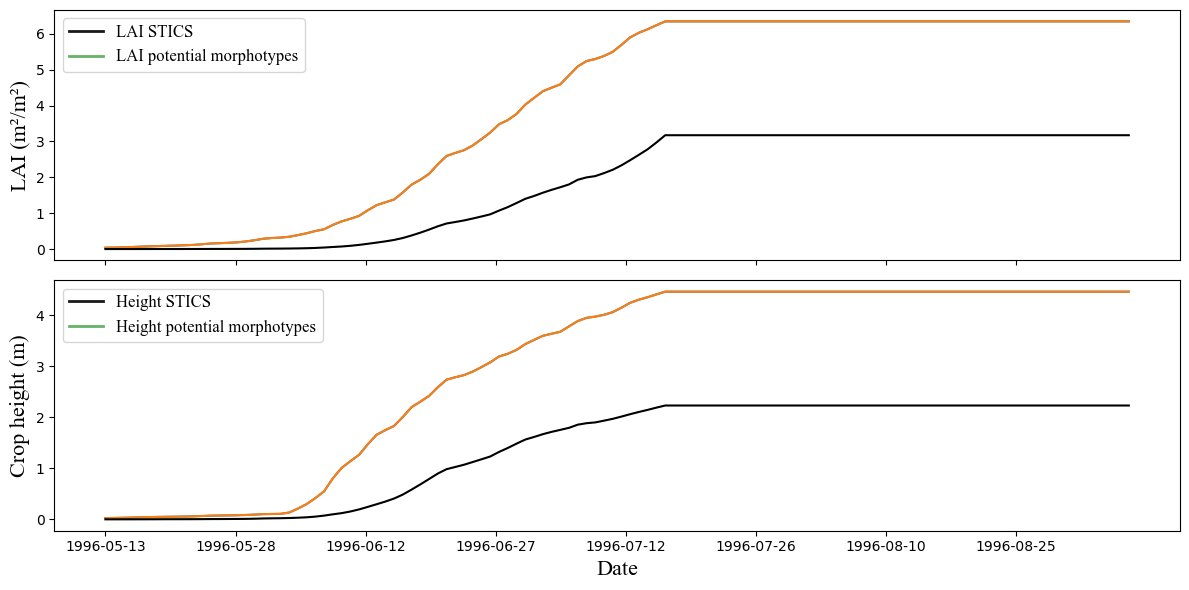

In [7]:
plot_constained_vs_pot(dates, pot_la, pot_h, leaf_area_plant, height_canopy, sowing_density, stics_color="black")

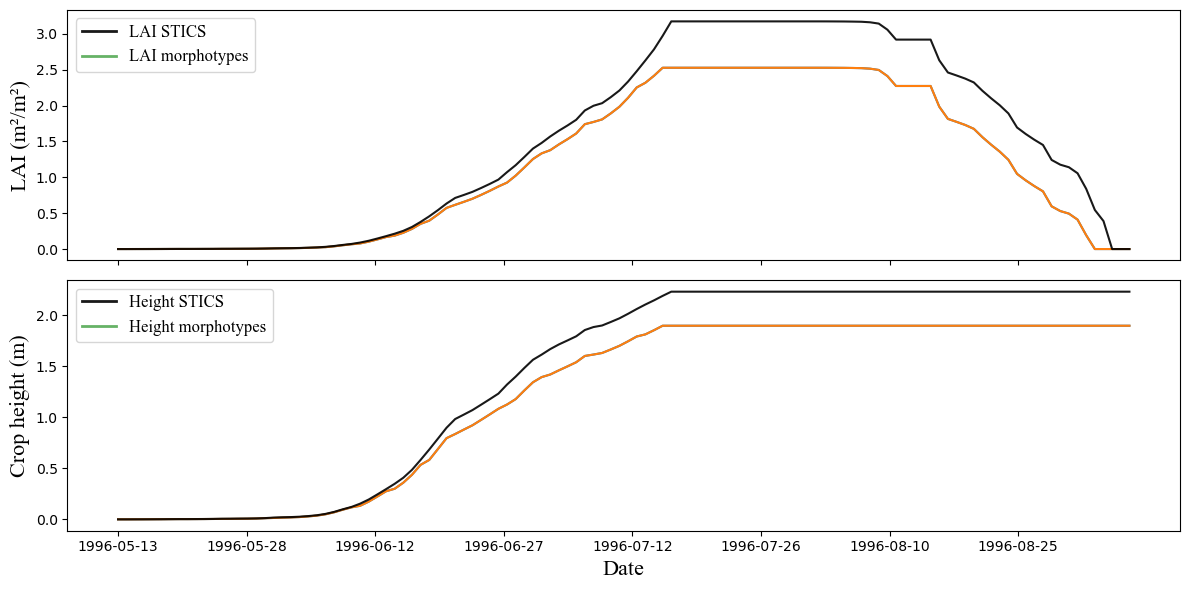

In [8]:
plot_constrainted_vs_realized(dates=dates, 
                              LA_archicrop=realized_la, 
                              height_archicrop=realized_h, 
                              leaf_area_plant=leaf_area_plant, 
                              sen_leaf_area_plant=sen_leaf_area_plant, 
                              height_canopy=height_canopy, 
                              sowing_density=sowing_density,
                              stics_color="black")


In [9]:
# Energy in Caribu : MJ.day-1
# Irradiance in Caribu : MJ.m[leaf]-2.day-1
# Incident PAR in STICS : MJ.m[soil]-2.day-1
# Absorbed PAR in STICS : MJ.m[soil]-2.day-1

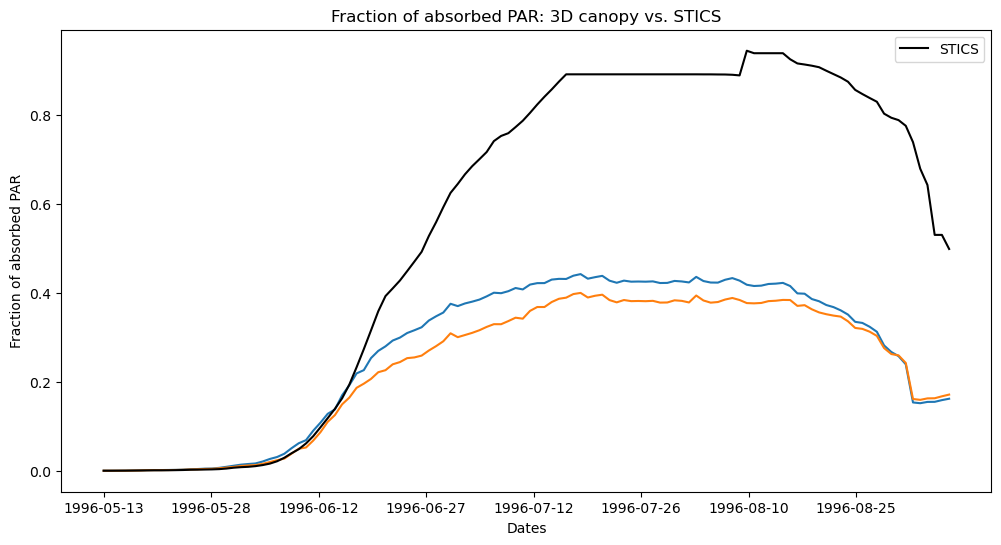

In [10]:
if nrj_per_plant[0][0] is not None:
    plot_faPAR(dates, nrj_per_plant, par_incident, par_stics, sowing_density, stics_color="black")

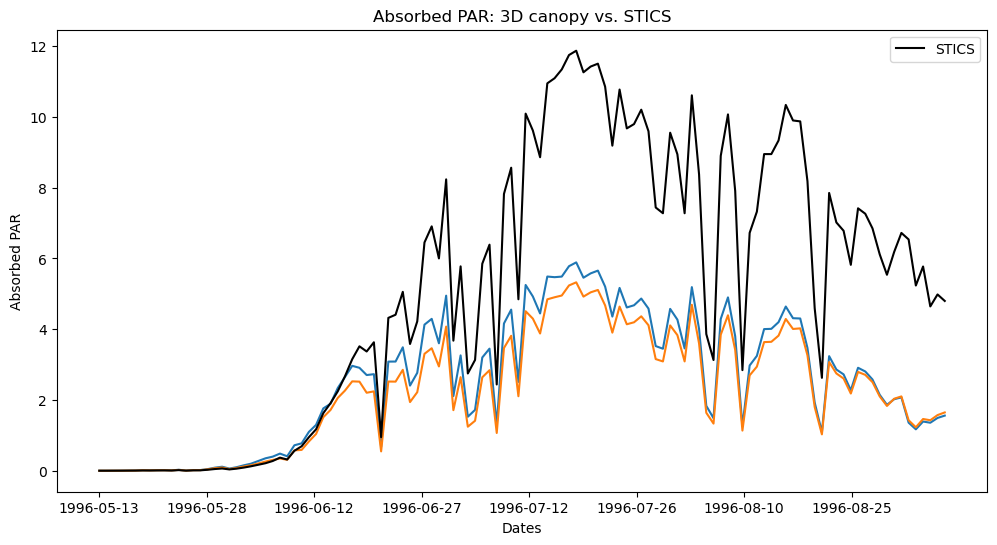

In [11]:
if nrj_per_plant[0][0] is not None:
    plot_PAR(dates, nrj_per_plant, par_incident, par_stics, sowing_density, stics_color="black")

In [12]:
# see if sum eabs and esoil = 1
# see tests caribu (cf light vege manager in oa incubator)
# compute memory 

$$ raint(t)=0.95⋅parsurrgG⋅trg(t)⋅(1−exp(−extinP⋅(lai(t)+eai(t)))) $$

$$ parsurrgG = 0.48 $$

$$ extinP(maize) = 0.7 $$

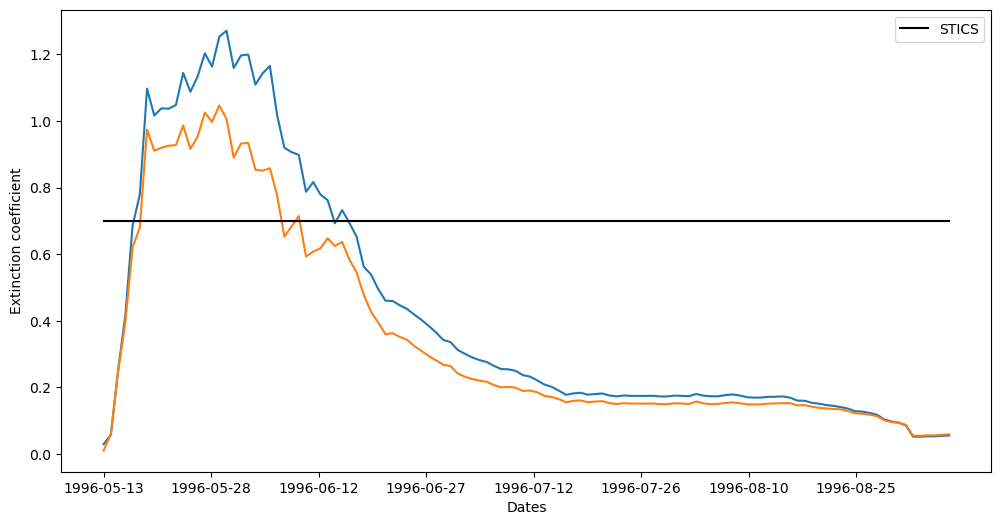

In [13]:
# Compute coef extinP
import math

extinP_list = []
extinP_sorghum = 0.7

for nrj_time_series in nrj_per_plant.values():
    extinP_per_sim = []
    for i,(nrj,par) in enumerate(zip(nrj_time_series, par_incident)):
        ratio_par_abs = nrj/par
        if ratio_par_abs <= 1:
            lai = leaf_area_plant[i]*sowing_density/10000 
            extinP = -1/lai * math.log(1-ratio_par_abs)
        else:
            extinP = 1
        extinP_per_sim.append(extinP)
    extinP_list.append(extinP_per_sim)

fig, ax = plt.subplots(figsize=(12, 6))
for curve in extinP_list:
    ax.plot(dates, curve)
ax.plot(dates, [extinP_sorghum]*len(dates), color="black", label="STICS")
ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
ax.set_xlabel("Dates") 
ax.set_ylabel("Extinction coefficient")
ax.legend()
plt.show()

In [14]:
"""
# vertical light interception
cs, ei, df = illuminate(scene, scene_unit='cm')
cs.plot(ei)


# diffuse light interception
sources = skys.sky_sources()
cs, ei, df = illuminate(scene, light=sources, scene_unit='cm')
cs.plot(ei)

# get score per plant
def score(res):
    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),
                              'area': res.area.sum()})
df['nump']=nump
df.groupby('nump').apply(score)
"""

"\n# vertical light interception\ncs, ei, df = illuminate(scene, scene_unit='cm')\ncs.plot(ei)\n\n\n# diffuse light interception\nsources = skys.sky_sources()\ncs, ei, df = illuminate(scene, light=sources, scene_unit='cm')\ncs.plot(ei)\n\n# get score per plant\ndef score(res):\n    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),\n                              'area': res.area.sum()})\ndf['nump']=nump\ndf.groupby('nump').apply(score)\n"